# NN training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/03-training/homework.ipynb)

В этой тетрадке мы решим нашу первую серьезную задачу - [Imagenette](https://github.com/fastai/imagenette#imagenette-1) 
(сабсет ImageNet) и поиграем с подбором гиперпараметров.

**Всегда поможет:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)

In [125]:
from copy import deepcopy

from tqdm import tqdm
import numpy as np
import os
from collections import defaultdict
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet18
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)
torch.set_deterministic(True)

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Data

Для обучения мы будем использовать облегченную версию датасета Imagenette с минимальной стороной равной 160 пикселям.  
Следующие две ячейки должны скачать и распаковать данные, после чего в текущей директории появится 
директория `imagenette2-160` со следующей структурой:

- ./imagenette2-160/
    - train/
        - {CLASS_ID}/{IMAGE_ID}.jpeg
    - val/
        - {CLASS_ID}/{IMAGE_ID}.jpeg

In [2]:
# download tar archive

! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

--2021-02-21 12:15:10--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  36.9MB/s    in 2.6s    

2021-02-21 12:15:12 (36.9 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



In [3]:
# extract files from archive

! tar -zxf imagenette2-160.tgz

## Задание 1
**(0.2 балла)** Напишите класс `ImagenetteDataset`, который мы будем использовать для обучения сетки.  

*Hints:* 

1. Нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`. 
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset)).
1. Для работы с картинками лучше использовать OpenCV: `pip install opencv-python-headless`.
1. Обратите внимание на то, что возвращает функция `cv2.imread`. 
Какой порядок каналов в полученном массиве?
1. В батче не может быть тензоров разного размера.

In [4]:
class ImagenetteDataset(Dataset):
    def __init__(self, train=True):
        self.data = []
        self._path = "imagenette2-160/"
        self._path += "train/" if train else "val/"
        self._label_mapper = {
            label: i for i, label in enumerate(
                [x for x in os.listdir(self._path) if ".DS_Store" not in x])  # какой-то DS_Store
        }
        for dir in [x for x in os.listdir(self._path) if ".DS_Store" not in x]:
            path = self._path + dir + "/"
            for sample in os.listdir(path):
                self.data.append((path + sample, self._label_mapper[dir]))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img, label = self.data[index]
        img = cv2.imread(img) / 255.
        img = cv2.resize(img, (160, 160))
        img = torch.Tensor(np.transpose(img, (2, 0, 1)))
        return dict(
            sample=img,
            label=label
        )

In [5]:
imagenet = ImagenetteDataset()

for k, v in imagenet[0].items():
    print(k, v)

sample tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9968, 1.0000, 0.9542],
         [1.0000, 1.0000, 1.0000,  ..., 0.9968, 1.0000, 0.9509],
         [0.9961, 0.9961, 0.9961,  ..., 0.9968, 1.0000, 0.9509],
         ...,
         [0.2359, 0.2373, 0.2223,  ..., 0.2320, 0.2313, 0.2307],
         [0.2294, 0.2373, 0.2223,  ..., 0.2007, 0.1980, 0.1922],
         [0.2150, 0.2333, 0.2256,  ..., 0.1778, 0.1902, 0.2092]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9968, 1.0000, 0.9542],
         [1.0000, 1.0000, 1.0000,  ..., 0.9968, 1.0000, 0.9509],
         [0.9961, 0.9961, 0.9961,  ..., 0.9968, 1.0000, 0.9509],
         ...,
         [0.5850, 0.5863, 0.5713,  ..., 0.5876, 0.5843, 0.5810],
         [0.5784, 0.5863, 0.5713,  ..., 0.5640, 0.5588, 0.5503],
         [0.5640, 0.5823, 0.5746,  ..., 0.5425, 0.5549, 0.5739]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9968, 1.0000, 0.9542],
         [1.0000, 1.0000, 1.0000,  ..., 0.9968, 1.0000, 0.9509],
         [0.9961, 0.9961, 0.9961,  ..., 0.9968, 1.0

In [6]:
imagenet_loader = DataLoader(imagenet, batch_size=4)
for batch in imagenet_loader:
    for k, v in batch.items():
        print(k, v.shape)
    break

sample torch.Size([4, 3, 160, 160])
label torch.Size([4])


## Задание 2
**(0.1 балла)** Перенесите свой класс `Trainer` и создайте его инстанс.

*Hints:*

1. Можете взять любую архитектуру сети из предыдущей домашки/семинара или из `torchvision.models`: 
[link](https://pytorch.org/vision/stable/models.html#classification)

In [34]:
class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/',
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.train_writer = SummaryWriter(log_dir=tboard_log_dir + "train/")
        self.val_writer = SummaryWriter(log_dir=tboard_log_dir + "val/")
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf') # +inf

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                all_grads = []
                for name, p in model.named_parameters():
                    if not p.requires_grad:
                        continue
                    v = np.linalg.norm(p.grad.data.cpu().numpy())
                    all_grads += [v]
                    if "weight" in name:
                        self.train_writer.add_scalar(f"grad_{name}", v, global_step=self.global_step)
                        
                self.train_writer.add_scalar(f"grads", np.mean(all_grads), global_step=self.global_step)
                model.post_train_batch()
                for k, v in details.items():
                    self.train_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses = []
            
            val_logs = defaultdict(list)
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                for k, v in details.items():
                    val_logs[k].append(v)
                    
            val_logs = {k: np.mean(v) for k, v in val_logs.items()}
            for k, v in val_logs.items():
                self.val_writer.add_scalar(k, v, global_step=self.global_step)

            val_loss = np.mean(val_losses)
            model.post_val_stage(val_loss)

            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        # exp((1-t) * log(left) + t * log(right))
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

        return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

In [8]:
class VeryModel(nn.Module):
    def __init__(self, lr_scheduler=None, lr_scheduler_type=None,
                 load_pretrained=True, freeze_body=False):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")
        
        net = resnet18(pretrained=load_pretrained)

        if freeze_body:
            for param in net.parameters():
                param.requires_grad = False
                
        net.fc = nn.Linear(in_features=512, out_features=10)
        self.inner = net

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample']
        y = batch['label']
        logits = self.inner(x)
        
        F.softmax(logits).argmax() == logits.argmax()

        loss = F.cross_entropy(logits, y) # весь выч граф
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc, loss=loss.item())

        return loss, metrics

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

In [9]:
model = VeryModel()
opt = torch.optim.SGD(model.parameters(), lr=0.2)
trainset = ImagenetteDataset(train=True)
valset = ImagenetteDataset(train=False)

trainer = Trainer(model, opt, trainset, valset, batch_size=128)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## Задание 3
**(0.1 балла)** Проведите LR Range Test и выберите LR в оптимальных границах.

*Requirement:* график в осях LR - loss должен быть в аутпуте ячейки.

In [10]:
logs = trainer.find_lr(min_lr=1e-4, max_lr=0.3, num_lrs=70)

finding LR: 100%|██████████| 70/70 [00:17<00:00,  3.97it/s]


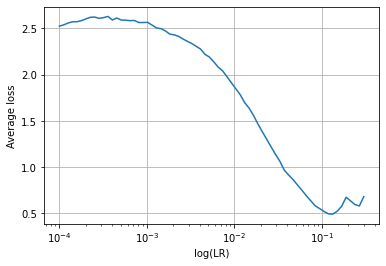

In [11]:
plt.grid(True)
plt.plot(logs["lr"], logs["avg_loss"])
plt.xscale("log")
plt.ylabel("Average loss")
plt.xlabel("log(LR)")
plt.show()

In [12]:
LEARNING_RATE = 1e-2

## Задание 4
**(0.2 балла)** Обучите сеть с выбранным LR. Остальные гиперпараметры выберите по своему усмотрению.

*Requirements:*
1. Логи экспериментов должен быть в отдельных папках, чтобы их можно было сравнить в тензорборде
(см. аргумент `log_dir` в [docs](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter)).
1. Метрика `Accuracy`.
1. На этапе валидации метрика должна считаться по всем валидационным объектам, а не отдельно по каждому батчу. 
В тензорборде после валидации должна появиться одна точка.

In [13]:
model = VeryModel()
opt = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

trainer = Trainer(model, opt, trainset, valset, batch_size=128, 
                  tboard_log_dir = "./resnet/")

In [14]:
trainer.train(10)

100%|██████████| 31/31 [00:07<00:00,  4.04it/s]


In [134]:
# %tensorboard --logdir ./resnet

## Задание 5
**(0.4+ балла)** Попробуйте различные гиперпараметры при обучении. Что дает набольший эффект?  
За каждый эксперимент с гиперпараметром из списка дается 0.1 балл:

1. Optimizer: adam, sgd, etc.
1. Batch size.
1. LR scheduler.
1. Freeze weights. Если вы используете предобученную сеть, то попробуйте заморозить тушку (body) и обучать только голову.
1. Weight initialization: zeros, ones, normal, uniform, etc.

*Requirement:* сделайте скриншот тензорборда (несколько, если считаете нужным) с кривыми обучения
(лоссы/метрики на трейне/валидации) проведенных экспериментов и приложите вместе с готовым ноутбуком в anytask.
Из скриншота должно быть понятно в чем заключался эксперимент и как проходило обучение.

*Hint 1:* не меняйте несколько гиперпараметров в одном эксперименте - так непонятно какой из них сыграл.  
*Hint 2:* для заморозки весов, нужно пробежать по параметрам и поставить флаг `param.requires_grad = False` 
(см. [PyTorch discuss](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2)).  
*Hint 3:* для инициализации придется итерироваться по параметрам. 
Менять их значения можно с помощью уже готовых функций: [PyTorch docs](https://pytorch.org/docs/stable/nn.init.html?highlight=init).

#### 1. Выбор оптимизатора


In [16]:
torch.cuda.empty_cache()
opt_test = VeryModel()
sgd = torch.optim.SGD(opt_test.parameters(), lr=LEARNING_RATE)
opt_trainer = Trainer(opt_test, sgd, trainset, valset, batch_size=128, 
                  tboard_log_dir = "./optimizer_test/" + "SGD_")
opt_trainer.train(10)

100%|██████████| 31/31 [00:07<00:00,  3.96it/s]


In [17]:
torch.cuda.empty_cache()

opt_test = VeryModel()
adam = torch.optim.Adam(opt_test.parameters(), lr=LEARNING_RATE)
opt_trainer = Trainer(opt_test, adam, trainset, valset, batch_size=128, 
                  tboard_log_dir = "./optimizer_test/" + "Adam_")
opt_trainer.train(10)

100%|██████████| 31/31 [00:07<00:00,  3.99it/s]


In [133]:
# %tensorboard --logdir ./optimizer_test

#### 2. Выбор размера батча

In [19]:
torch.cuda.empty_cache()

batch_sizes = [128, 256, 512]

for batch in batch_sizes:
    batch_test = VeryModel()
    opt = torch.optim.SGD(batch_test.parameters(), lr=LEARNING_RATE)
    batch_trainer = Trainer(batch_test, opt, trainset, valset, batch_size=batch, 
                  tboard_log_dir = "./batch_test/" + "batch_" + str(batch))
    batch_trainer.train(10)

100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


In [132]:
# %tensorboard --logdir ./batch_test

#### 3. LR scheduler

In [22]:
torch.cuda.empty_cache()

sched_test = VeryModel()
sched_opt = torch.optim.SGD(sched_test.parameters(), lr=LEARNING_RATE)
sched_trainer = Trainer(sched_test, sched_opt, trainset, valset, batch_size=128, 
                  tboard_log_dir = "./scheduler_test/" + "no_sched_")
sched_trainer.train(10)

100%|██████████| 31/31 [00:08<00:00,  3.79it/s]


In [24]:
torch.cuda.empty_cache()

sched_test = VeryModel(lr_scheduler=lr_scheduler, lr_scheduler_type="per_epoch")
sched_opt = torch.optim.SGD(sched_test.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=sched_opt, gamma=0.9)

sched_trainer = Trainer(sched_test, sched_opt, trainset, valset, batch_size=128, 
                  tboard_log_dir = "./scheduler_test/" + "sched_")
sched_trainer.train(10)

NameError: ignored

In [ ]:
%tensorboard --logdir ./scheduler_test

#### 4. Заморозка тушки

In [35]:
torch.cuda.empty_cache()

freeze = [True, False]

for f in freeze:
    freeze_test = VeryModel(freeze_body=f)
    opt = torch.optim.SGD(freeze_test.parameters(), lr=LEARNING_RATE)
    freeze_trainer = Trainer(freeze_test, opt, trainset, valset, batch_size=128, 
                  tboard_log_dir = "./freeze_test/" + "freeze_" + str(f))
    freeze_trainer.train(10)

100%|██████████| 31/31 [00:07<00:00,  4.15it/s]


In [131]:
# %tensorboard --logdir ./freeze_test

### Задание 6 (бонус)
**(0.2 балла, бонус)** Покажите на каких классах лучшая сеть ошибается сильнее всего.

*Requirement:* выведите матрицу ошибок в виде heatmap.

In [119]:
torch.cuda.empty_cache()
device = torch.cuda.current_device()

val_loader = DataLoader(valset, batch_size=1)

predicted_labels = []
true_labels = []

model.eval()

for batch in tqdm(val_loader):
    torch.cuda.empty_cache()
    batch = {k: v.to(device) for k, v in batch.items()}
    sample, label = batch["sample"], batch["label"]
    predicted_labels.append(np.argmax(model(sample).cpu().detach().numpy()))
    true_labels.append(label.cpu().detach().numpy())

100%|██████████| 3925/3925 [00:24<00:00, 160.88it/s]


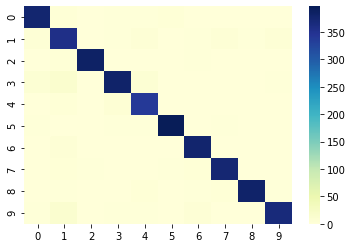

In [130]:
sns.heatmap(confusion_matrix(true_labels, predicted_labels), cmap="YlGnBu")

In [124]:
# на картинке совсем плохо видно, но хуже всего дела со вторым классом - это собачки
confusion_matrix(true_labels, predicted_labels)

array([[377,   4,   0,   2,   2,   4,   0,   0,   0,   0],
       [  5, 357,   1,   2,   5,   0,   3,   5,   2,   6],
       [  1,   4, 386,   0,   0,   0,   2,   1,   1,   0],
       [  8,  14,   0, 383,   9,   1,   0,   0,   1,   3],
       [  1,   4,   1,   7, 340,   1,   1,   0,   1,   1],
       [  3,   1,   0,   3,   2, 397,   0,   3,   0,   0],
       [  0,   6,   0,   1,   0,   0, 379,   1,   0,   0],
       [  1,   4,   2,   1,   0,   2,   4, 375,   0,   1],
       [  0,   2,   0,   0,   4,   1,   3,   4, 383,   2],
       [  2,  13,   0,   2,   2,   0,   6,   1,   0, 368]])